In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import GPyOpt
import xgboost as xgb
import lightgbm
from sklearn import preprocessing
import seaborn as sns
lbl = preprocessing.LabelEncoder()

In [2]:
#read data
df = pd.read_csv('data_for_test.csv',index_col=0)

In [3]:
#make subgroups by material
df_groupby = df.groupby("material",as_index=True)
df_groupby.mean()["target"]

material
A    0.000000
C    0.092726
D    0.014201
O    0.109589
S    0.050282
Name: target, dtype: float64

In [4]:
#remove material A
df = df[df.material!="A"]
df['material'] = lbl.fit_transform(df['material'].astype(str))

In [5]:
#null
df.isnull().sum() 

install_year      0
material          0
diameter        314
env_dat_0         0
env_dat_1         0
               ... 
env_dat_141     470
env_dat_142     470
env_dat_143      92
env_dat_144      92
target            0
Length: 149, dtype: int64

In [6]:
corr_mat = df.corr()

In [7]:
#make datasets
def make_data(df):
    target = pd.Series(df.target)
    explanatory = df.loc[:,df.columns[:148]]
    train_x, test_x, train_y, test_y = train_test_split(explanatory, target, test_size=0.1, shuffle=True)
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True)
    return  train_x, valid_x, train_y, valid_y,test_x,test_y

In [8]:
#cross_validation and get score
def get_score(x):
    eta ,max_depth= x[0]
    max_depth = int(max_depth)
    models = []
    aucs=[]
    row_no_list = list(range(len(train_y)))
    K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=42)
    for train_cv_no, eval_cv_no in K_fold.split(row_no_list, train_y):
        train_x_cv = train_x.iloc[train_cv_no, :]
        train_y_cv = pd.Series(train_y).iloc[train_cv_no]
        valid_x_cv = train_x.iloc[eval_cv_no, :]
        valid_y_cv = pd.Series(train_y).iloc[eval_cv_no]
        dtrain = xgb.DMatrix(train_x_cv, label=train_y_cv)
        dvalid = xgb.DMatrix(valid_x_cv, label=valid_y_cv)
        param = {'max_depth': max_depth,'eta':eta, 'objective': 'binary:hinge','eval_metric': 'auc' ,'scale_pos_weight':0.1,'verbosity':0}
        evallist = [ (dtrain, 'train'),(dvalid, 'valid')]
        num_round = 1000

        evaluation_results = {}   
        bst = xgb.train(param, dtrain, num_round,evallist,evals_result=evaluation_results,early_stopping_rounds=5, verbose_eval=0)
        dtest = xgb.DMatrix(test_x)
        pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
        score = accuracy_score(test_y, pred)
        score = roc_auc_score(test_y, pred)
        aucs.append(score)
        models.append(bst)
    return np.mean(aucs)

In [9]:
#function for prediction
def predict(df):
    
    bounds = [{'name': 'eta', 'type': 'continuous', 'domain': (0.01,0.3)} , {'name':'max_depth','type':'discrete','domain':list(range(1,10,1))}]
    bo = GPyOpt.methods.bayesian_optimization.BayesianOptimization(
        f=get_score, domain=bounds, model_type='GP', acquisition_type='EI', initial_design_numdata=51, maximize=True)
    bo.run_optimization()
    bo.plot_acquisition()
    return bo

In [10]:
#function for test
def test(train_x,valid_x,train_y,valid_y,bo):
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {'max_depth': int(bo.x_opt[1]),'eta':bo.x_opt[0], 'objective': 'binary:hinge','eval_metric': 'auc','scale_pos_weight':8,'verbosity':0}
    num_round = 1000
    evallist = [(dvalid, 'eval'), (dtrain, 'train')]
    bst = xgb.train(param, dtrain, num_round,evallist,early_stopping_rounds=10,verbose_eval=0)


    dtest = xgb.DMatrix(test_x)
    pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
    xgb.plot_importance(bst)
    score = accuracy_score(test_y, pred)
    print('accuracy:{0:.4f}'.format(score))
    score = roc_auc_score(test_y, pred)
    print('roc_auc_score:{0:.4f}'.format(score))

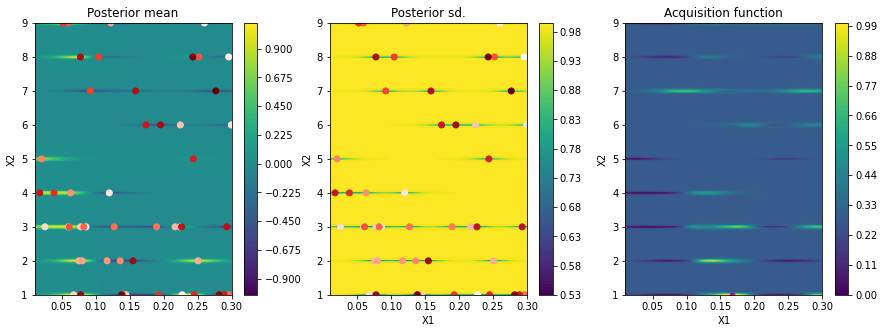

In [11]:
#whole dataset
train_x, valid_x, train_y, valid_y,test_x,test_y = make_data(df)
bo = predict(df)

accuracy:0.6937
roc_auc_score:0.7039


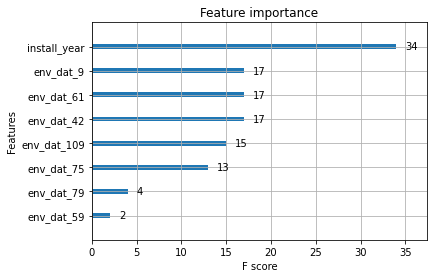

In [12]:
#test
#I set the auc score as the evaluation metrics because of the imbalanced data.
test(train_x,valid_x,train_y,valid_y,bo)

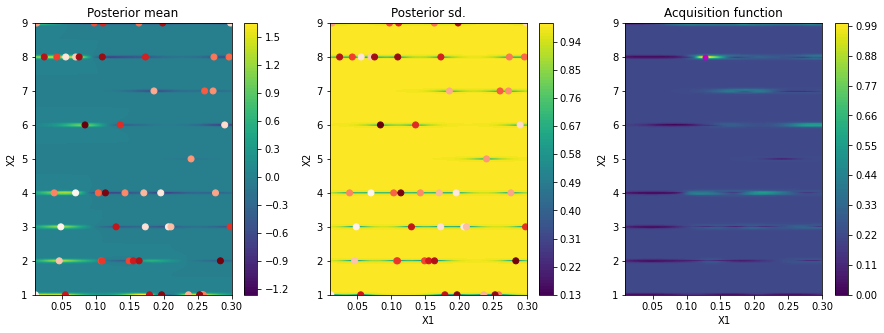

accuracy:0.5501
roc_auc_score:0.6233


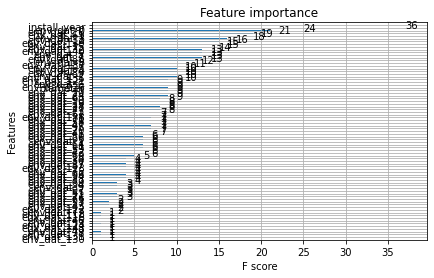

In [13]:
#each dataset (material C)
df_C = df_groupby.get_group('C')
df_C['material'] = lbl.fit_transform(df_C['material'].astype(str))
train_x, valid_x, train_y, valid_y,test_x,test_y = make_data(df_C)
bo = predict(df)
#test
test(train_x,valid_x,train_y,valid_y,bo)

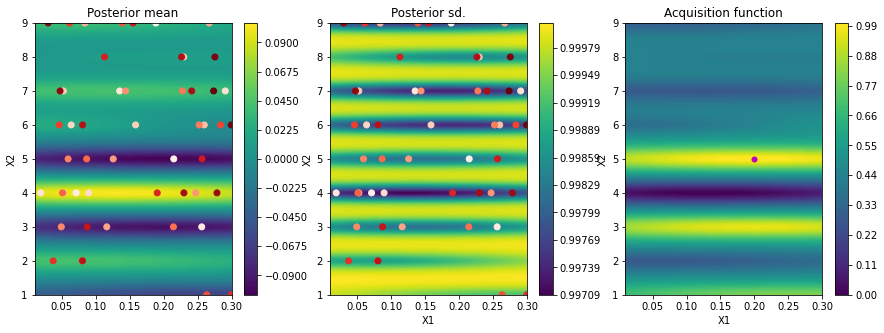

accuracy:0.6447
roc_auc_score:0.6604


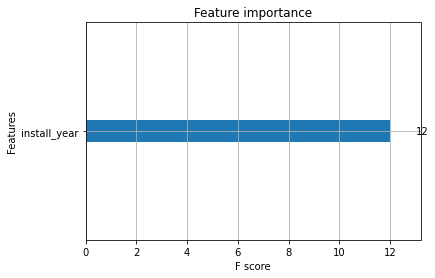

In [42]:
#each dataset (material D)
df_D = df_groupby.get_group('D')
df_D['material'] = lbl.fit_transform(df_D['material'].astype(str))
train_x, valid_x, train_y, valid_y,test_x,test_y = make_data(df_D)
bo = predict(df)
test(train_x,valid_x,train_y,valid_y,bo)